In this lab, you will implement the t-SNE algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
# These are for plotting
def plot_2d(points, points_color, title, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

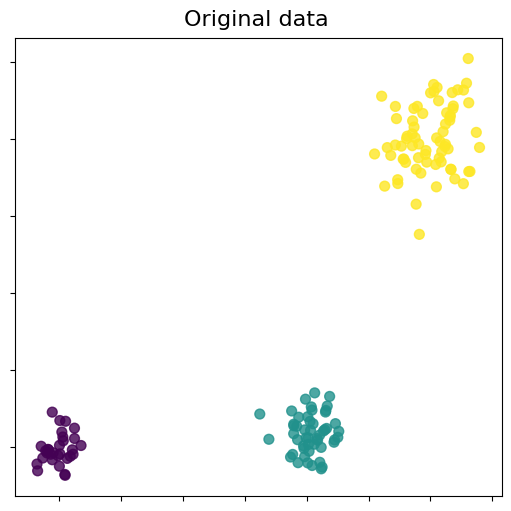

In [3]:
# We will use a mixture of Gaussian with three clusters as data
n1 = 30
n2 = 50
n3 = 70
X1 = np.random.multivariate_normal([0, 0], [[1,0],[0,1]], size=n1)
X2 = np.random.multivariate_normal([20, 0], [[2,0],[0,2]], size=n2)
X3 = np.random.multivariate_normal([30, 20], [[4,0],[0,4]], size=n3)
X = np.concatenate((X1, X2, X3), axis=0)

Y = [0] * n1 + [1] * n2 + [2] * n3

n = n1 + n2 + n3

plot_2d(X, Y, "Original data", figsize=(5,5))

In [4]:
# This function is for computing the squared distance between data
def compute_squared_dist(X):
  return np.sum((X[None, :] - X[:, None]) ** 2, 2)

In [12]:
# This function is for computing the squared distance between data
def compute_squared_dist(X):
  return np.sum((X[None, :] - X[:, None]) ** 2, 2)
# Here, I provide the code for computing p_ij
# See the 'compute_joint_p' function and use it for your t-SNE implementation

# The below function is for computing conditional distribution for the idx-th
# data
from scipy.stats import entropy
def cond_dist_gaussian(v, idx, s):
  n = len(v)
  v2 = np.exp(-v / (2 * s * s))
  v2 = v2 + 1e-10
  v2[idx] = 0
  v2 = v2 / v2.sum()

  return v2

# The below function computes proper scaling factor s, depending on the
# perplexity value, based on the binary search
def find_proper_std(v_dist, idx, log_perp, thres_perp=1e-5, s_min=1e-10, s_max=1e10):
  s = 1
  H_min = -100
  H_max = -1 + thres_perp
  while True:
    s = (s_min + s_max) / 2
    p = cond_dist_gaussian(v_dist, idx, s)
    H = entropy(p, base=2)

    if H <= log_perp:
      s_min = s
      H_min = H
    else:
      s_max = s
      H_max = H
    
    if H_max - H_min < thres_perp:
      break
    
  return s, H, p

# The below function computes the joint distribution p_ij
# Specifically, the (i,j)-th entry of a matrix P is p_ij
def compute_joint_p(X, perp):
  D = compute_squared_dist(X)
  P = np.zeros(D.shape)
  log_perp = np.log2(perp)

  for i in range(n):
    v = D[i]
    (s, H, p) = find_proper_std(v, i, log_perp)
    P[i] = p

  P = (P + P.transpose()) / (2 * n)
  return P


def compute_grad(P, U):
  Q = compute_pairwise_distances(U) ** 2
  np.fill_diagonal(Q, 1e-12)
  
  PQ_diff = P - Q
  grad = 4.0 * np.dot(np.diag(np.sum(PQ_diff, axis=1)), U)
  grad -= np.dot(PQ_diff.T, U)
  
  return grad

In [17]:
"""TODO: implement the 'my_tsne' function."""
def my_tsne(data, target_dim, n_iter, lr, momentum, perp):
# Here, you will implement t-SNE
# You can freely use "subfunctions" that helps implementing this function
# e.g., I used 'find_proper_std' and 'cond_dist_gaussian' for 'compute_joint_p'

# The below indicates input/output of the compute_weights function.
# Input
# data: a data matrix of size n x p
# target_dim: the target dimension (we will choose two later)
# n_iter: the number of iterations for the gradient descent
# lr: the learning rate for the gradient descent
# momentum: the momentum parameter for the gradient descent
# perp: perplexity for your t-SNE

# Output
# U: an embedding matrix of size n x target_dim
#    - its i-th row denotes the embedding for the i-th data
    U = np.random.normal(0.0, 0.0001, (X.shape[0], target_dim))
    
    dU = np.zeros_like(U)
    
    for i in range(n_iter):
        P = compute_joint_p(X=X, perp=perp)
        grad = compute_grad(P=P, U=U)
        
        dU = momentum * dU - lr * grad
        U += dU
        if (i + 1) % 50 == 0:
            cost = np.sum(P * np.log(P / np.sum(P)))
            print(f"Iteration {i}, Cost {cost:.3f}")
    return U

In [18]:
# hyperparameters for t-SNE
target_dim = 2 # our target dimension, as always
n_iter = 1000 # the number of iterations for GD
lr = 100 # the learning rate for GD
momentum = 0.8 # the momentum parameter for GD

In [19]:
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=5)
plot_2d(U, Y, 'Perplexity=5', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=10)
plot_2d(U, Y, 'Perplexity=10', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=20)
plot_2d(U, Y, 'Perplexity=20', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=30)
plot_2d(U, Y, 'Perplexity=30', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=50)
plot_2d(U, Y, 'Perplexity=50', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=100)
plot_2d(U, Y, 'Perplexity=100', figsize=(5, 5))

KeyboardInterrupt: 

In [39]:
U = np.random.normal(0.0, 0.0001, (X.shape[0], target_dim))
compute_joint_probabilities(X, U, perplexity=5)

array([[5.99595190e-001, 6.40414015e-003, 5.66656987e-003, ...,
        5.48173479e-030, 4.16034038e-026, 1.29425389e-029],
       [1.85049924e-007, 4.60686214e-001, 1.34442319e-002, ...,
        9.02718108e-100, 4.61316296e-087, 1.60743105e-098],
       [2.96971042e-007, 1.89246327e-002, 5.52031933e-001, ...,
        3.55283523e-094, 5.03354681e-082, 5.65983767e-093],
       ...,
       [4.05915522e-057, 8.62474002e-060, 3.72396216e-059, ...,
        4.60136754e-001, 1.02056199e-008, 5.97596849e-002],
       [1.85199082e-044, 8.76338391e-047, 3.33075556e-046, ...,
        6.69979828e-008, 4.63332341e-001, 3.45970801e-007],
       [2.09834818e-065, 1.75970950e-068, 9.76095961e-068, ...,
        3.62054834e-002, 4.22090670e-009, 3.87570879e-001]])

In [37]:
from tsne import tsne, compute_joint_probabilities
lr = 0.01
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=5, verbose=True)
plot_2d(U, Y, 'Perplexity=5', figsize=(5, 5))
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=10, verbose=True)
plot_2d(U, Y, 'Perplexity=10', figsize=(5, 5))
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=20, verbose=True)
plot_2d(U, Y, 'Perplexity=20', figsize=(5, 5))
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=30, verbose=True)
plot_2d(U, Y, 'Perplexity=30', figsize=(5, 5))
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=50, verbose=True)
plot_2d(U, Y, 'Perplexity=50', figsize=(5, 5))
U = tsne(X, target_dim, n_iter=n_iter, learning_rate=lr, perplexity=100, verbose=True)
plot_2d(U, Y, 'Perplexity=100', figsize=(5, 5))

Iteration 50, Cost: -993.011
Iteration 100, Cost: -993.011
Iteration 150, Cost: -993.011
Iteration 200, Cost: -993.011
Iteration 250, Cost: -993.011
Iteration 300, Cost: -993.011
Iteration 350, Cost: -993.011
Iteration 400, Cost: -993.011
Iteration 450, Cost: -993.011
Iteration 500, Cost: -993.011
Iteration 550, Cost: -993.011
Iteration 600, Cost: -993.011


KeyboardInterrupt: 

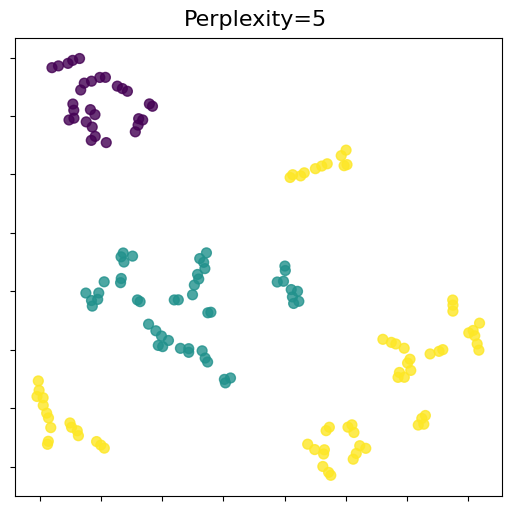

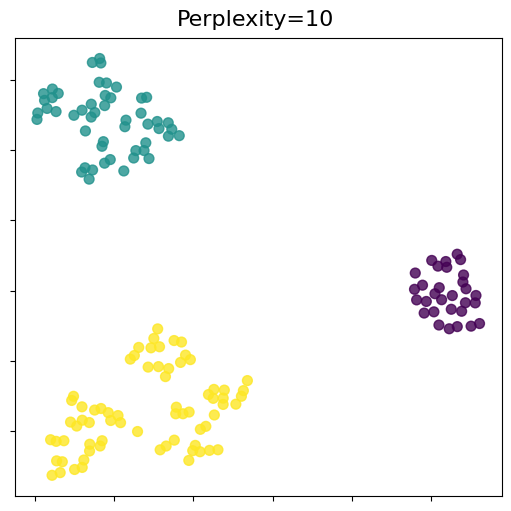

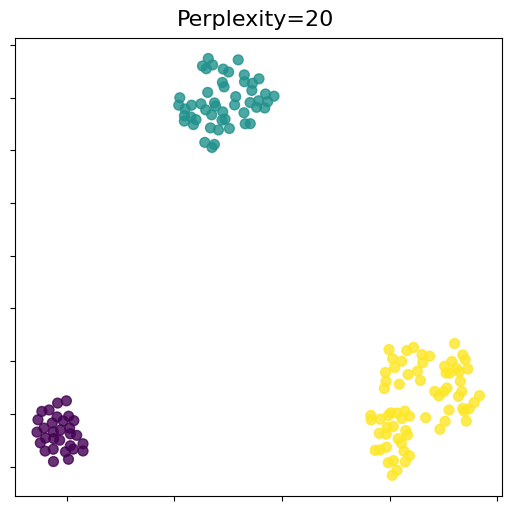

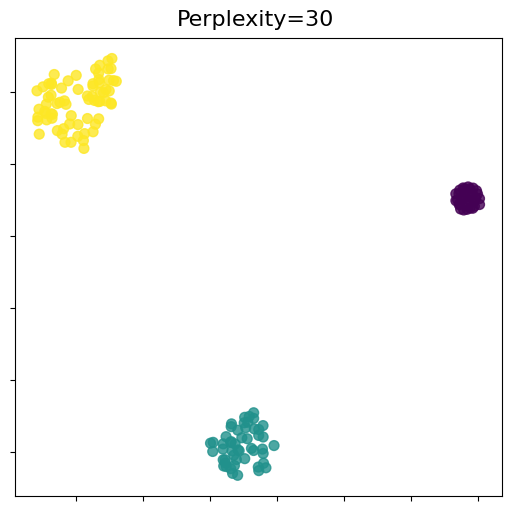

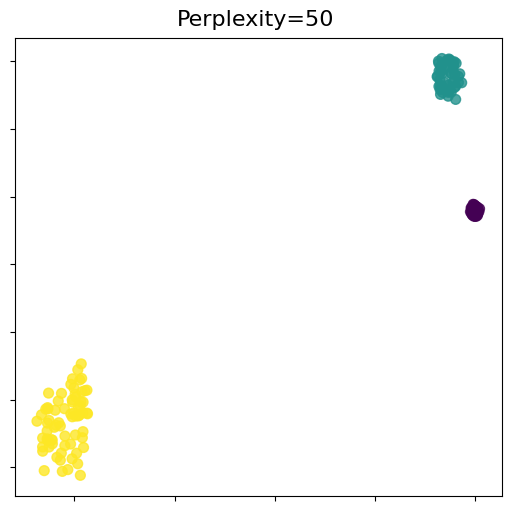

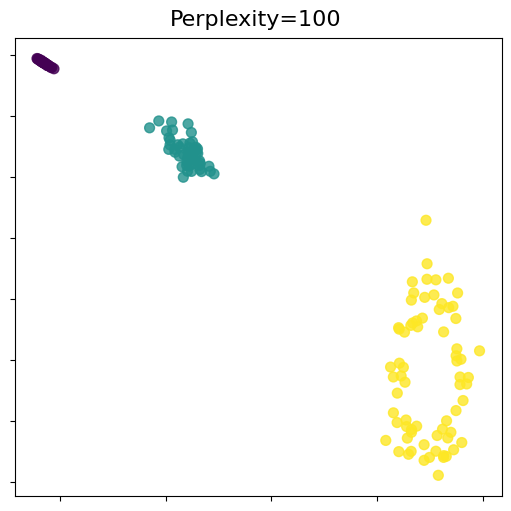

In [ ]:
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=5)
plot_2d(U, Y, 'Perplexity=5', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=10)
plot_2d(U, Y, 'Perplexity=10', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=20)
plot_2d(U, Y, 'Perplexity=20', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=30)
plot_2d(U, Y, 'Perplexity=30', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=50)
plot_2d(U, Y, 'Perplexity=50', figsize=(5, 5))
U = my_tsne(X, target_dim, n_iter, lr, momentum, perp=100)
plot_2d(U, Y, 'Perplexity=100', figsize=(5, 5))